# Deep Generative Models - Assignment 2

## Problem 3 - Normalizing Flow

In [1]:
import numpy as np
from matplotlib import pyplot as plt

import torch
from torch import nn, optim
from torchvision import datasets, transforms

### Global Parameters

In [2]:
# training epochs
max_epochs = 32

# batch size
batch_size = 128

# learning rate
learning_rate = 1e-3

# learning rate decay interval
lr_decay_p = 6

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Load Dataset

In [3]:
def get_mnist_data(device, batch_size):

    train_loader = torch.utils.data.DataLoader(
        datasets.MNIST(
            'data', train=True, download=True,
            transform=transforms.ToTensor()
        ),
        batch_size=batch_size, shuffle=True
    )

    test_loader = torch.utils.data.DataLoader(
        datasets.MNIST(
            'data', train=False, download=True,
            transform=transforms.ToTensor()
        ),
        batch_size=batch_size, shuffle=True
    )

    return train_loader, test_loader

train_loader, test_loader = get_mnist_data(device, batch_size)

100%|██████████| 9912422/9912422 [00:00<00:00, 73538603.34it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 38962912.13it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 39508542.78it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 25605549.42it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



### Base Models

In [4]:
class CouplingLayer(nn.Module):

    def __init__(self, dim, mask):
        super().__init__()

        self.dim = dim
        self.register_buffer('mask', mask)

        self.s = nn.Sequential(
            nn.Linear(dim, dim//4),
            nn.ReLU(),
            nn.Linear(dim//4, dim),
            nn.Tanh()
        )

        self.t = nn.Sequential(
            nn.Linear(dim, dim//4),
            nn.ReLU(),
            nn.Linear(dim//4, dim//4),
            nn.ReLU(),
            nn.Linear(dim//4, dim),
        )

    def forward(self, x):

        mx = x * self.mask
        s = self.s(mx)
        t = self.t(mx)

        z = mx + (1 - self.mask) * (x * torch.exp(s) + t)
        log_abs_det_jacobian = (1 - self.mask) * s

        return z, log_abs_det_jacobian.sum(1)

    def backward(self, z):

        mz = z * self.mask
        s = self.s(mz)
        t = self.t(mz)

        x = mz + (1 - self.mask) * (z - t) * torch.exp(-s)
        log_abs_det_jacobian = - (1 - self.mask) * s

        return x, log_abs_det_jacobian.sum(1)

In [5]:
class SequentialFlow(nn.Sequential):

    def forward(self, x):
        total_log_det = 0
        for module in list(self.children()):
            x, log_det = module(x)
            total_log_det += log_det
        return x, total_log_det

    def backward(self, z):
        total_log_det = 0
        for module in reversed(list(self.children())):
            z, log_det = module.backward(z)
            total_log_det += log_det
        return z, total_log_det

### Real NVP NF Model

In [6]:
class RealNVP(nn.Module):

    def __init__(self, input_dim, n_flows=4):
        super().__init__()

        blocks = []
        mask = torch.arange(0, input_dim) % 2
        for i in range(n_flows):
            blocks.append(CouplingLayer(input_dim, mask))
            mask = 1 - mask

        self.flows = SequentialFlow(*blocks)

    def logprob(self, z):
        log_probs = - 0.5 * (z ** 2) - 0.5 * np.log(2 * np.pi)
        log_prob = log_probs.sum(-1)
        return log_prob

    def forward(self, x):
        return self.flows.forward(x)

    def backward(self, z):
        return self.flows.backward(z)

    def sample(self, samples=1):
        z = torch.normal(0, 1, size=(samples, 28*28)).to(device)
        x, d = self.backward(z)
        return x

### Training

In [7]:
nf = RealNVP(28 * 28).to(device)
optimizer = optim.Adam(nf.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.StepLR(optimizer, lr_decay_p, gamma=0.5)

In [8]:
def nf_train_step(x_batch):

    x_batch = x_batch.reshape(x_batch.shape[0], -1)
    x_batch = x_batch.to(device)

    optimizer.zero_grad()
    z, log_det = nf.forward(x_batch)

    prior_log_prob = nf.logprob(z)
    loss = -torch.mean(prior_log_prob + log_det)

    loss.backward()
    optimizer.step()

    return loss.item()

In [9]:
train_loss, test_loss = [], []

for epoch in range(max_epochs):

    tmp_loss = []
    for batch_idx, (x_batch, y_batch) in enumerate(train_loader):

        loss = nf_train_step(x_batch)
        tmp_loss.append(loss)

    train_loss.append(np.array(tmp_loss).mean())

    tmp_loss = []
    for batch_idx, (x_batch, y_batch) in enumerate(test_loader):
        x_batch = x_batch.reshape(x_batch.size(0), -1).to(device)
        with torch.no_grad():
            z, log_det = nf.forward(x_batch)
            prior_log_prob = nf.logprob(z)
            loss = -torch.mean(prior_log_prob + log_det)
            loss = loss.item()

        tmp_loss.append(loss)

    test_loss.append(np.array(tmp_loss).mean())

    print(f'epoch {(epoch+1):3} \t-\t train loss = {train_loss[-1]:.2f} \t-\t test loss = {test_loss[-1]:.2f}')
    scheduler.step()

epoch   1 	-	 train loss = -509.12 	-	 test loss = -603.37
epoch   2 	-	 train loss = -620.00 	-	 test loss = -642.97
epoch   3 	-	 train loss = -658.06 	-	 test loss = -666.18
epoch   4 	-	 train loss = -671.32 	-	 test loss = -685.83
epoch   5 	-	 train loss = -694.02 	-	 test loss = -701.68
epoch   6 	-	 train loss = -699.85 	-	 test loss = -703.59
epoch   7 	-	 train loss = -720.67 	-	 test loss = -725.66
epoch   8 	-	 train loss = -727.65 	-	 test loss = -729.91
epoch   9 	-	 train loss = -732.19 	-	 test loss = -735.76
epoch  10 	-	 train loss = -733.12 	-	 test loss = -739.92
epoch  11 	-	 train loss = -741.01 	-	 test loss = -740.60
epoch  12 	-	 train loss = -744.28 	-	 test loss = -746.17
epoch  13 	-	 train loss = -751.63 	-	 test loss = -751.86
epoch  14 	-	 train loss = -753.31 	-	 test loss = -751.45
epoch  15 	-	 train loss = -755.12 	-	 test loss = -752.98
epoch  16 	-	 train loss = -754.19 	-	 test loss = -757.41
epoch  17 	-	 train loss = -758.85 	-	 test loss = -758.

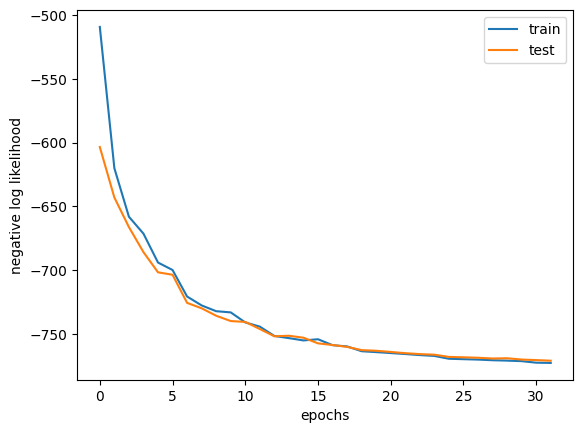

In [10]:
plt.plot(train_loss, label='train')
plt.plot(test_loss, label='test')
plt.xlabel('epochs')
plt.ylabel('negative log likelihood')
plt.legend()
plt.show()

### Evaluation

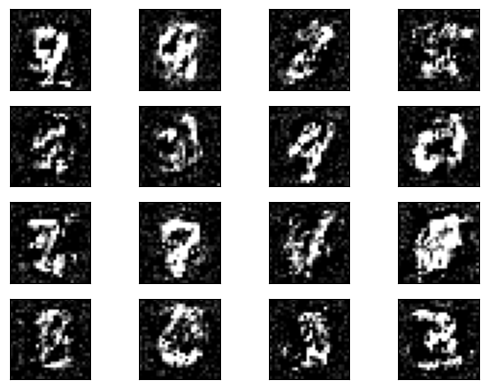

In [19]:
with torch.no_grad():
    x_hat = nf.sample(16)

x_hat = x_hat.cpu().numpy()
x_hat = x_hat.reshape((16, 28, 28))

fig, axs = plt.subplots(4, 4)
for i in range(16):
    axs[i//4][i % 4].imshow(x_hat[i].clip(0, 1), cmap='gray')
    axs[i//4][i % 4].set_xticks([])
    axs[i//4][i % 4].set_yticks([])

plt.show()